In [2]:
# import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# helper packages
import matplotlib.pyplot as plt
import tqdm as tqdm
import numpy as np

In [3]:
# Generate transforms to apply to the images in order to perform data augmentation
from torchvision import transforms

# Chain together scaling and cropping transformations (and convert to pytorch tensors)
transform = transforms.Compose([transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1),shear=10), transforms.ToTensor()])

In [6]:
# Load MNIST training and test datasets using torchvision
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [9]:
# Create training and test dataloaders (batch size of 32)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

torch.Size([32, 1, 28, 28])
torch.Size([32])


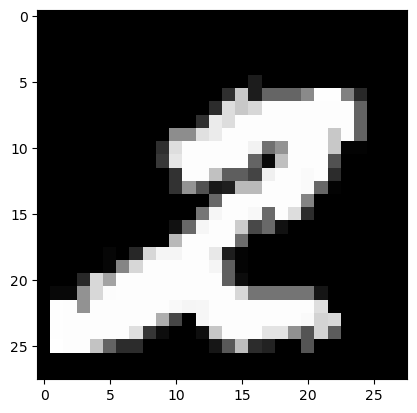

In [17]:
# View MNIST image using MNIST an look at the shape of a batch
image, label = next(iter(trainloader))
print(image.shape)
print(label.shape)

# Plot the first image in the batch
plt.imshow(image[0,0,:,:], cmap='gray')
plt.show()

In [19]:
# Build the critic network class (standard convolutional architecture)
# The output will be a single value which scores the input image (based on how realistic it is)

class Critic(nn.Module):
    def __init__(self):
        super(Critic,self).__init__()
        # This takes in a 28 x 28 image and outputs a single value
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1), # 28 x 28 x 1 -> 28 x 28 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2), # 28 x 28 x 32 -> 14 x 14 x 32
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), # 14 x 14 x 32 -> 14 x 14 x 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2), # 14 x 14 x 64 -> 7 x 7 x 64
            nn.Conv2d(64, 8, kernel_size = 3), # 7 x 7 x 64 -> 5 x 5 x 8
            nn.Flatten(), 
            nn.Linear(5*5*8, 1), # 5 x 5 x 8 -> 1
            nn.Tanh()
        )
    # Put image through layers and return output
    def forward(self, x):
        return self.layers(x)
        

In [32]:
# Build the generator network class (standard convolutional architecture)
# The generator takes in a random vector and outputs a 28 x 28 image
# The random vector is a 24 dimensional Gaussian distribution with mean 0 and variance 1
# The generator network will have a standard deconv architecture

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # This takes in a 24 dimensional vector and outputs a 28 x 28 image
        self.layers = nn.Sequential(
            nn.Linear(24, 5*5*8), 
            nn.Unflatten(1, (8, 5, 5)),
            nn.ConvTranspose2d(8, 64, kernel_size = 3), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, padding = 1), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(32, 16, kernel_size = 3, padding = 1), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.ConvTranspose2d(16, 1, kernel_size = 3, padding = 1),
            nn.Sigmoid()
        )   
    # Put random vector through layers and return output
    def forward(self, x):
        return self.layers(x)


In [33]:
# Instantiate the generator and critic
generator = Generator()
critic = Critic()

In [34]:
# Define optimisers for generator and critic
g_optimiser = optim.Adam(generator.parameters(), lr=0.0005)
c_optimiser = optim.Adam(critic.parameters(), lr=0.0005)

In [35]:
# Define a list to store the losses for the two networks
c_losses = []
g_losses = []

In [36]:
# Train generator and critic networks using Wasserstein loss with l2 weight regularisation
# Wasserstein loss for the critic network is C(G(Z)) - C(X) where Z is a random vector and X is a real image
# This encourages the critic to score real images highly and generated images poorly
# The generator loss is -C(G(Z)) which encourages the generator to produce images that score highly with the critic

def train_one_epoch():
    # Iterate over training data
    for real_images, label in tqdm.tqdm(trainloader):
        # Zero the gradients
        c_optimiser.zero_grad()
        # generate random vector
        z = torch.randn(32,24)
        # Pass random vector through generator
        fake_image = generator(z)
        critic_loss = critic(fake_image).mean() - critic(real_images).mean()
        critic_loss.backward()
        c_losses.append(critic_loss.item())
        c_optimiser.step()

        # train the generator
        # zero gradients for the generator
        g_optimiser.zero_grad()
        # generate random vector
        z = torch.randn(32,24)
        # Pass random vector through generator
        fake_image = generator(z)
        generator_loss = -critic(fake_image).mean()
        generator_loss.backward()
        g_losses.append(generator_loss.item())
        g_optimiser.step()

for i in range(3):
    train_one_epoch()
    print(np.mean(g_losses), np.mean(c_losses))

100%|██████████| 1875/1875 [1:10:13<00:00,  2.25s/it]     


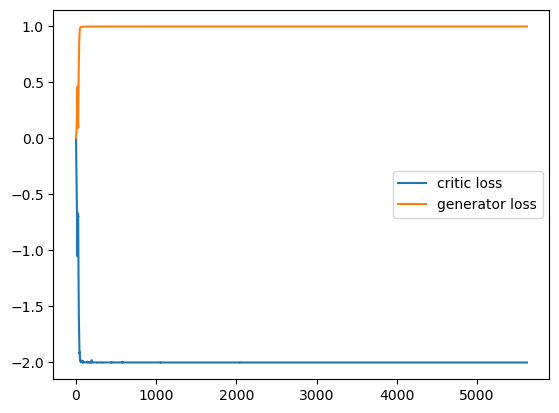

In [37]:
# Plot the losses for the generator and critic networks
plt.plot(c_losses, label='critic loss')
plt.plot(g_losses, label='generator loss')
plt.legend()
plt.show()